# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 3 - Reinforcement Learning by mixing Screen and RAM

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Make the Atari games and their environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")
env_ram = gym.make("Asterix-ram-v0")

# Preprocess the environments (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)

# Stack the RAM states by FRAME_STACK_SIZE
env_ram = FrameStack(env_ram, FRAME_STACK_SIZE)

# Seed the Atari game environments
env.seed(SEED_VALUE), env_ram.seed(SEED_VALUE)

([1337, 17452119], [1337, 17452119])

In [3]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation spaces:")
print(f"\tImage: {env.observation_space.shape}\n\tRAM: {env_ram.observation_space.shape}")
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation spaces:
	Image: (84, 84, 5)
	RAM: (640,)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


## Task 3.1

For architecture, refer to report appendix.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [5]:
SCALE = 255

In [6]:
def normalise(ram, scale):
    return ram/scale

In [7]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the image and RAM input shapes
# for the DDQN models (game environment observation space)
IMG_INPUT_SHAPE = env.observation_space.shape
RAM_INPUT_SHAPE = env_ram.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [8]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [9]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        # The DDQN agent learning rate attribute
        # used for the Adam optimiser when building 
        # our model architecture.
        self.lr = lr
        
        # DDQN agent memory represented by a SumTree class instance
        # (faster batch sampling, thus, better runtime performance)
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the mixed (image frame + RAM state) input model architecture. 
        We shift from Sequential configuration to a functional one. This approach is used 
        when handling models with non-linear topology, shared layers, multiple inputs/outputs.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        # Define the kernel initialiser. We adopt the He uniform
        # variance scaling initialiser for improved training stability.
        kernel_init = HeUniform()
        
        # Define the RAM input layer
        img_input = Input(shape=IMG_INPUT_SHAPE)
        
        # Set the Conv2D layers
        conv_lyr = Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', kernel_initializer=kernel_init)(img_input)
        conv_lyr = Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        conv_lyr = Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init)(conv_lyr)
        
        # Flatten the convolved image input.
        flatten_lyr = Flatten()(conv_lyr)
        
        # Define the RAM input layer
        ram_input = Input(shape=RAM_INPUT_SHAPE)
        
        # We pass RAM environment states as the inputs to our Dense layers 
        dense_lyr = Dense(512, activation='relu', kernel_initializer=kernel_init)(ram_input)
        dense_lyr = Dense(256, activation='relu', kernel_initializer=kernel_init)(dense_lyr)
        
        # Merge the Conv2D and Dense layer outputs into a single large vector via concatenation
        concat_lyr = concatenate([flatten_lyr, dense_lyr])
        
        # Pass the concatenated tensor the last Dense output layer
        output_lyr = Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init)(concat_lyr)
        
        # Specify the inputs and outputs of our mixed model architecture
        model = Model(inputs=[img_input, ram_input], outputs=output_lyr)
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
#         model.summary()
        return model
            
    def update_target(self):
        """Update the target network with the online mixed network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, img_state, ram_state, step):
        """Based on the epsilon agent chooses whether to explore the environment
        or exploit the current image and RAM game states.
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict([img_state.reshape(-1, *IMG_INPUT_SHAPE),\
                                                ram_state.reshape(-1, *RAM_INPUT_SHAPE)])
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        Use the batch of image and RAM state input samples.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        img_no_state = np.zeros(IMG_INPUT_SHAPE)
        ram_no_state = np.zeros(RAM_INPUT_SHAPE)
        
        # Get the image and RAM previous states from the batch observations
        prev_img_states = np.array([sample_list[0][0] for _, sample_list in batch])
        prev_ram_states = np.array([sample_list[1][0] for _, sample_list in batch])
        
        # Get the image and RAM next states from the batch observations
        # No state if done = True
        img_next_states = np.array([(img_no_state if sample_list[0][4] is True else sample_list[0][3]) for _, sample_list in batch])
        ram_next_states = np.array([(ram_no_state if sample_list[1][4] is True else sample_list[1][3]) for _, sample_list in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict([prev_img_states, prev_ram_states])
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict([img_next_states, ram_next_states])
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict([img_next_states, ram_next_states])
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        img_X = np.zeros((len(batch), *IMG_INPUT_SHAPE))
        ram_X = np.zeros((len(batch), *RAM_INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Get the sample list from the batch
            sample_list = batch[idx][1]
            
            # Unpack the current batch samples
            curr_img_state, action, reward, _, done = sample_list[0]
            curr_ram_state, _, _, _, _ = sample_list[1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            img_X[idx] = curr_img_state
            ram_X[idx] = curr_ram_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return ([img_X, ram_X], Y, errors)
    
    def save_to_memory(self, img_sample, ram_sample, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample_list = [img_sample, ram_sample]
        if step <= EXPLORATION_STEPS:
            error = abs(img_sample[2])  # Reward
            self.memory.add(error, sample_list)
        else:
            X, Y, errors = self.get_train_data([(0, sample_list)])
            self.memory.add(errors[0], sample_list)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        
        # Sample a batch error-observation pairs
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        # Fit the online DDQN and update the loss value
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 3.2

In [10]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent()  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the DDQN agent after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update the target DDQN every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environments once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environments and get the initial observations
        img_res = env.reset()
        ram_res = env_ram.reset()
        
        
        # Convert the observations to NumPy arrays
        # since we need such arrays to carry out the ddqn_agent training
        img_state = np.array(img_res)
        ram_state = normalise(np.array(ram_res), SCALE)
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(img_state, ram_state, step)

    # Take a step in the game environments
    img_next_state, reward, done, _ = env.step(action)
    ram_next_state, _, _, _ = env_ram.step(action)
    
    # Convert to NumPy arrays and normalise the RAM input state
    img_next_state = np.array(img_next_state)
    ram_next_state = normalise(np.array(ram_next_state), SCALE)
    
    img_sample = (img_state, action, reward, img_next_state, done)
    ram_sample = (ram_state, action, reward, ram_next_state, done)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(img_sample, ram_sample, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
#     env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    
    # Assing the current states to the next states
    img_state = img_next_state
    ram_state = ram_next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 181/1000000 (0.02%)	Loss:   inf

c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 322/1000000 (0.03%)	Loss:   inf	AVG reward: 100	Total mean: 300.0
	Action step: 800/1000000 (0.08%)	Loss:   inf	AVG reward: 200	Total mean: 450.0
	Action step: 1082/1000000 (0.11%)	Loss:   inf	AVG reward: 33	Total mean: 333.3333333333333
	Action step: 1433/1000000 (0.14%)	Loss:   inf	AVG reward: 83	Total mean: 312.5
	Action step: 1751/1000000 (0.18%)	Loss:   inf	AVG reward: 83	Total mean: 300.0
	Action step: 2504/1000000 (0.25%)	Loss:   inf	AVG reward: 300	Total mean: 400.0
	Action step: 2788/1000000 (0.28%)	Loss:   inf	AVG reward: 50	Total mean: 364.2857142857143
	Action step: 3084/1000000 (0.31%)	Loss:   inf	AVG reward: 66	Total mean: 343.75
	Action step: 3342/1000000 (0.33%)	Loss:   inf	AVG reward: 66	Total mean: 327.77777777777777
	Action step: 3687/1000000 (0.37%)	Loss:   inf	AVG reward: 83	Total mean: 320.0
	Action step: 4100/1000000 (0.41%)	Loss:   inf	AVG reward: 100	Total mean: 318.1818181818182
	Action step: 4384/1000000 (0.44%)	Loss:   inf	AVG reward: 50	Total 

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20265/1000000 (2.03%)	Loss: 2.081318	AVG reward: 183	Total mean: 279.4642857142857
	Action step: 20535/1000000 (2.05%)	Loss: 3.200728	AVG reward: 33	Total mean: 276.3157894736842
	Action step: 20863/1000000 (2.09%)	Loss: 2.665999	AVG reward: 50	Total mean: 274.13793103448273
	Action step: 21156/1000000 (2.12%)	Loss: 2.684907	AVG reward: 33	Total mean: 271.1864406779661
	Action step: 21483/1000000 (2.15%)	Loss: 2.427554	AVG reward: 50	Total mean: 269.1666666666667
	Action step: 21823/1000000 (2.18%)	Loss: 1.569165	AVG reward: 116	Total mean: 270.4918032786885
	Action step: 22163/1000000 (2.22%)	Loss: 2.093143	AVG reward: 66	Total mean: 269.35483870967744
	Action step: 22448/1000000 (2.24%)	Loss: 1.812933	AVG reward: 33	Total mean: 266.6666666666667
	Action step: 22719/1000000 (2.27%)	Loss: 1.819335	AVG reward: 50	Total mean: 264.84375
	Action step: 22968/1000000 (2.30%)	Loss: 2.236781	AVG reward: 50	Total mean: 263.0769230769231
	Action step: 23445/1000000 (2.34%)	Loss: 1.

	Action step: 79022/1000000 (7.90%)	Loss: 0.254066	AVG reward: 66	Total mean: 281.4159292035398
	Action step: 79316/1000000 (7.93%)	Loss: 0.713575	AVG reward: 116	Total mean: 281.7180616740088
	Action step: 79686/1000000 (7.97%)	Loss: 0.564728	AVG reward: 83	Total mean: 281.57894736842104
	Action step: 79958/1000000 (8.00%)	Loss: 0.491635	AVG reward: 66	Total mean: 281.2227074235808
	Action step: 80320/1000000 (8.03%)	Loss: 0.716481	AVG reward: 100	Total mean: 281.30434782608694
	Action step: 80832/1000000 (8.08%)	Loss: 0.382384	AVG reward: 116	Total mean: 281.6017316017316
	Action step: 81146/1000000 (8.11%)	Loss: 0.661933	AVG reward: 100	Total mean: 281.6810344827586
	Action step: 81417/1000000 (8.14%)	Loss: 0.491916	AVG reward: 33	Total mean: 280.90128755364805
	Action step: 81825/1000000 (8.18%)	Loss: 0.442068	AVG reward: 150	Total mean: 281.62393162393164
	Action step: 82096/1000000 (8.21%)	Loss: 0.528030	AVG reward: 50	Total mean: 281.06382978723406
	Action step: 82382/1000000 (8

	Action step: 137033/1000000 (13.70%)	Loss: 0.590062	AVG reward: 33	Total mean: 315.1399491094148
	Action step: 137337/1000000 (13.73%)	Loss: 0.800291	AVG reward: 116	Total mean: 315.2284263959391
	Action step: 137739/1000000 (13.77%)	Loss: 0.504644	AVG reward: 116	Total mean: 315.3164556962025
	Action step: 138136/1000000 (13.81%)	Loss: 0.563889	AVG reward: 166	Total mean: 315.7828282828283
	Action step: 138452/1000000 (13.85%)	Loss: 0.437187	AVG reward: 100	Total mean: 315.74307304785896
	Action step: 138771/1000000 (13.88%)	Loss: 0.813021	AVG reward: 116	Total mean: 315.8291457286432
	Action step: 139069/1000000 (13.91%)	Loss: 0.785125	AVG reward: 116	Total mean: 315.91478696741854
	Action step: 139365/1000000 (13.94%)	Loss: 0.562155	AVG reward: 133	Total mean: 316.125
	Action step: 139763/1000000 (13.98%)	Loss: 0.371857	AVG reward: 133	Total mean: 316.33416458852867
	Action step: 140042/1000000 (14.00%)	Loss: 0.852394	AVG reward: 100	Total mean: 316.29353233830847
	Action step: 140

	Action step: 167014/1000000 (16.70%)	Loss: 0.531650	AVG reward: 216	Total mean: 336.34453781512605
	Action step: 167365/1000000 (16.74%)	Loss: 0.276859	AVG reward: 166	Total mean: 336.68763102725364
	Action step: 167711/1000000 (16.77%)	Loss: 0.635885	AVG reward: 116	Total mean: 336.7154811715481
	Action step: 168010/1000000 (16.80%)	Loss: 0.490846	AVG reward: 116	Total mean: 336.74321503131523
	Action step: 168328/1000000 (16.83%)	Loss: 0.547245	AVG reward: 83	Total mean: 336.5625
	Action step: 168620/1000000 (16.86%)	Loss: 0.525560	AVG reward: 50	Total mean: 336.1746361746362
	Action step: 168975/1000000 (16.90%)	Loss: 0.427341	AVG reward: 100	Total mean: 336.0995850622407
	Action step: 169267/1000000 (16.93%)	Loss: 0.861125	AVG reward: 216	Total mean: 336.74948240165634
	Action step: 169539/1000000 (16.95%)	Loss: 0.698245	AVG reward: 83	Total mean: 336.5702479338843
	Action step: 169973/1000000 (17.00%)	Loss: 0.758220	AVG reward: 150	Total mean: 336.8041237113402
	Action step: 1703

	Action step: 196376/1000000 (19.64%)	Loss: 0.629992	AVG reward: 100	Total mean: 348.5688729874776
	Action step: 196650/1000000 (19.66%)	Loss: 0.754119	AVG reward: 116	Total mean: 348.57142857142856
	Action step: 196980/1000000 (19.70%)	Loss: 0.526201	AVG reward: 83	Total mean: 348.39572192513367
	Action step: 197258/1000000 (19.73%)	Loss: 0.552719	AVG reward: 66	Total mean: 348.1316725978648
	Action step: 197654/1000000 (19.77%)	Loss: 0.720005	AVG reward: 166	Total mean: 348.4014209591474
	Action step: 198018/1000000 (19.80%)	Loss: 0.740488	AVG reward: 166	Total mean: 348.67021276595744
	Action step: 198719/1000000 (19.87%)	Loss: 0.563109	AVG reward: 400	Total mean: 350.17699115044246
	Action step: 199129/1000000 (19.91%)	Loss: 0.530412	AVG reward: 166	Total mean: 350.4416961130742
	Action step: 199503/1000000 (19.95%)	Loss: 0.667092	AVG reward: 150	Total mean: 350.61728395061726
	Action step: 199943/1000000 (19.99%)	Loss: 0.867596	AVG reward: 216	Total mean: 351.1443661971831
	Action

	Action step: 226767/1000000 (22.68%)	Loss: 0.924375	AVG reward: 100	Total mean: 364.3302180685358
	Action step: 227028/1000000 (22.70%)	Loss: 0.659917	AVG reward: 66	Total mean: 364.0746500777605
	Action step: 227565/1000000 (22.76%)	Loss: 0.859725	AVG reward: 300	Total mean: 364.90683229813664
	Action step: 228059/1000000 (22.81%)	Loss: 0.882188	AVG reward: 350	Total mean: 365.968992248062
	Action step: 228474/1000000 (22.85%)	Loss: 0.792210	AVG reward: 250	Total mean: 366.5634674922601
	Action step: 228758/1000000 (22.88%)	Loss: 0.845186	AVG reward: 83	Total mean: 366.3833075734158
	Action step: 229172/1000000 (22.92%)	Loss: 0.751604	AVG reward: 183	Total mean: 366.6666666666667
	Action step: 229447/1000000 (22.94%)	Loss: 0.547997	AVG reward: 100	Total mean: 366.56394453004623
	Action step: 229811/1000000 (22.98%)	Loss: 0.507277	AVG reward: 150	Total mean: 366.6923076923077
	Action step: 230111/1000000 (23.01%)	Loss: 0.648138	AVG reward: 116	Total mean: 366.6666666666667
	Action ste

	Action step: 257203/1000000 (25.72%)	Loss: 1.109556	AVG reward: 233	Total mean: 378.55172413793105
	Action step: 257767/1000000 (25.78%)	Loss: 0.568496	AVG reward: 250	Total mean: 379.0633608815427
	Action step: 258231/1000000 (25.82%)	Loss: 0.723968	AVG reward: 216	Total mean: 379.43603851444294
	Action step: 258706/1000000 (25.87%)	Loss: 0.848146	AVG reward: 300	Total mean: 380.1510989010989
	Action step: 259064/1000000 (25.91%)	Loss: 0.780526	AVG reward: 133	Total mean: 380.1783264746228
	Action step: 259577/1000000 (25.96%)	Loss: 0.830035	AVG reward: 316	Total mean: 380.958904109589
	Action step: 260174/1000000 (26.02%)	Loss: 0.782420	AVG reward: 266	Total mean: 381.53214774281804
	Action step: 260613/1000000 (26.06%)	Loss: 0.695975	AVG reward: 233	Total mean: 381.9672131147541
	Action step: 260862/1000000 (26.09%)	Loss: 0.415433	AVG reward: 116	Total mean: 381.92360163710777
	Action step: 261410/1000000 (26.14%)	Loss: 0.605698	AVG reward: 250	Total mean: 382.425068119891
	Action 

	Action step: 289798/1000000 (28.98%)	Loss: 0.823340	AVG reward: 116	Total mean: 395.1732673267327
	Action step: 290326/1000000 (29.03%)	Loss: 0.629312	AVG reward: 283	Total mean: 395.7354758961681
	Action step: 290743/1000000 (29.07%)	Loss: 0.606107	AVG reward: 166	Total mean: 395.8641975308642
	Action step: 291064/1000000 (29.11%)	Loss: 0.608140	AVG reward: 83	Total mean: 395.68434032059184
	Action step: 291609/1000000 (29.16%)	Loss: 0.690175	AVG reward: 250	Total mean: 396.12068965517244
	Action step: 291881/1000000 (29.19%)	Loss: 0.653705	AVG reward: 116	Total mean: 396.0639606396064
	Action step: 292257/1000000 (29.23%)	Loss: 0.553346	AVG reward: 183	Total mean: 396.25307125307125
	Action step: 293029/1000000 (29.30%)	Loss: 0.533355	AVG reward: 450	Total mean: 397.4233128834356
	Action step: 293446/1000000 (29.34%)	Loss: 0.688308	AVG reward: 216	Total mean: 397.7328431372549
	Action step: 293677/1000000 (29.37%)	Loss: 0.753249	AVG reward: 133	Total mean: 397.7356181150551
	Action 

	Action step: 325638/1000000 (32.56%)	Loss: 0.498135	AVG reward: 200	Total mean: 415.4882154882155
	Action step: 326120/1000000 (32.61%)	Loss: 0.510892	AVG reward: 266	Total mean: 415.9192825112108
	Action step: 326601/1000000 (32.66%)	Loss: 0.348502	AVG reward: 283	Total mean: 416.4053751399776
	Action step: 327270/1000000 (32.73%)	Loss: 0.683713	AVG reward: 366	Total mean: 417.17002237136467
	Action step: 327696/1000000 (32.77%)	Loss: 0.799848	AVG reward: 250	Total mean: 417.5418994413408
	Action step: 328032/1000000 (32.80%)	Loss: 0.698402	AVG reward: 133	Total mean: 417.52232142857144
	Action step: 328433/1000000 (32.84%)	Loss: 0.449258	AVG reward: 183	Total mean: 417.670011148272
	Action step: 328862/1000000 (32.89%)	Loss: 0.972482	AVG reward: 150	Total mean: 417.70601336302894
	Action step: 329325/1000000 (32.93%)	Loss: 0.563724	AVG reward: 300	Total mean: 418.2424916573971
	Action step: 329630/1000000 (32.96%)	Loss: 0.751080	AVG reward: 133	Total mean: 418.22222222222223
	Action

	Action step: 391912/1000000 (39.19%)	Loss: 0.797405	AVG reward: 216	Total mean: 439.29924242424244
	Action step: 392441/1000000 (39.24%)	Loss: 0.805009	AVG reward: 266	Total mean: 439.64049195837276
	Action step: 392758/1000000 (39.28%)	Loss: 1.018562	AVG reward: 150	Total mean: 439.6502835538752
	Action step: 393196/1000000 (39.32%)	Loss: 0.439170	AVG reward: 200	Total mean: 439.80169971671387
	Action step: 393577/1000000 (39.36%)	Loss: 0.449865	AVG reward: 183	Total mean: 439.9056603773585
	Action step: 393899/1000000 (39.39%)	Loss: 0.646225	AVG reward: 100	Total mean: 439.7737983034873
	Action step: 394304/1000000 (39.43%)	Loss: 0.901137	AVG reward: 216	Total mean: 439.9717514124294
	Action step: 394580/1000000 (39.46%)	Loss: 0.748453	AVG reward: 100	Total mean: 439.8400752587018
	Action step: 394979/1000000 (39.50%)	Loss: 0.828857	AVG reward: 200	Total mean: 439.9906015037594
	Action step: 395241/1000000 (39.52%)	Loss: 0.519837	AVG reward: 150	Total mean: 440.0
	Action step: 39581

	Action step: 427911/1000000 (42.79%)	Loss: 0.689092	AVG reward: 283	Total mean: 456.54082528533803
	Action step: 428441/1000000 (42.84%)	Loss: 0.927710	AVG reward: 300	Total mean: 456.9298245614035
	Action step: 428773/1000000 (42.88%)	Loss: 0.847841	AVG reward: 183	Total mean: 457.011393514461
	Action step: 429109/1000000 (42.91%)	Loss: 0.713967	AVG reward: 116	Total mean: 456.91768826619966
	Action step: 429542/1000000 (42.95%)	Loss: 0.659960	AVG reward: 266	Total mean: 457.2178477690289
	Action step: 430129/1000000 (43.01%)	Loss: 0.891020	AVG reward: 316	Total mean: 457.6486013986014
	Action step: 430726/1000000 (43.07%)	Loss: 1.032619	AVG reward: 333	Total mean: 458.12227074235807
	Action step: 431276/1000000 (43.13%)	Loss: 0.752513	AVG reward: 333	Total mean: 458.59511343804536
	Action step: 431698/1000000 (43.17%)	Loss: 0.975863	AVG reward: 250	Total mean: 458.8491717523976
	Action step: 432071/1000000 (43.21%)	Loss: 0.790312	AVG reward: 216	Total mean: 459.0156794425087
	Action

	Action step: 501966/1000000 (50.20%)	Loss: 0.547487	AVG reward: 100	Total mean: 493.02147239263803
	Action step: 502388/1000000 (50.24%)	Loss: 0.651303	AVG reward: 216	Total mean: 493.1417624521073
	Action step: 502947/1000000 (50.29%)	Loss: 0.681670	AVG reward: 216	Total mean: 493.26186830015314
	Action step: 503469/1000000 (50.35%)	Loss: 1.320428	AVG reward: 333	Total mean: 493.6495791889824
	Action step: 504068/1000000 (50.41%)	Loss: 0.544674	AVG reward: 383	Total mean: 494.151376146789
	Action step: 504633/1000000 (50.46%)	Loss: 0.745125	AVG reward: 300	Total mean: 494.46142093200916
	Action step: 504982/1000000 (50.50%)	Loss: 0.987114	AVG reward: 150	Total mean: 494.42748091603056
	Action step: 505514/1000000 (50.55%)	Loss: 0.708359	AVG reward: 300	Total mean: 494.7368421052632
	Action step: 506355/1000000 (50.64%)	Loss: 0.763952	AVG reward: 450	Total mean: 495.3887195121951
	Action step: 506663/1000000 (50.67%)	Loss: 0.491266	AVG reward: 116	Total mean: 495.2779893373953
	Action

	Action step: 575686/1000000 (57.57%)	Loss: 0.534789	AVG reward: 183	Total mean: 515.5207624234173
	Action step: 575966/1000000 (57.60%)	Loss: 0.763000	AVG reward: 83	Total mean: 515.3401360544218
	Action step: 576650/1000000 (57.66%)	Loss: 0.612329	AVG reward: 400	Total mean: 515.805574439157
	Action step: 577144/1000000 (57.71%)	Loss: 0.656321	AVG reward: 216	Total mean: 515.8967391304348
	Action step: 577509/1000000 (57.75%)	Loss: 0.453982	AVG reward: 133	Total mean: 515.8180583842499
	Action step: 578138/1000000 (57.81%)	Loss: 0.941172	AVG reward: 333	Total mean: 516.146540027137
	Action step: 578621/1000000 (57.86%)	Loss: 0.497354	AVG reward: 333	Total mean: 516.4745762711865
	Action step: 578985/1000000 (57.90%)	Loss: 0.632131	AVG reward: 166	Total mean: 516.4634146341464
	Action step: 579300/1000000 (57.93%)	Loss: 0.650387	AVG reward: 133	Total mean: 516.3845633039946
	Action step: 580115/1000000 (58.01%)	Loss: 0.768321	AVG reward: 466	Total mean: 516.9824086603518
	Action step:

	Action step: 612748/1000000 (61.27%)	Loss: 0.706308	AVG reward: 250	Total mean: 523.0992268041238
	Action step: 613325/1000000 (61.33%)	Loss: 0.533501	AVG reward: 350	Total mean: 523.4385061171926
	Action step: 613839/1000000 (61.38%)	Loss: 0.802812	AVG reward: 283	Total mean: 523.6486486486486
	Action step: 614149/1000000 (61.41%)	Loss: 0.835442	AVG reward: 116	Total mean: 523.5369774919615
	Action step: 614795/1000000 (61.48%)	Loss: 1.233868	AVG reward: 416	Total mean: 524.0038560411311
	Action step: 615138/1000000 (61.51%)	Loss: 0.662508	AVG reward: 100	Total mean: 523.8599871547848
	Action step: 615560/1000000 (61.56%)	Loss: 0.799500	AVG reward: 166	Total mean: 523.8446726572529
	Action step: 615955/1000000 (61.60%)	Loss: 1.053849	AVG reward: 183	Total mean: 523.8614496472097
	Action step: 616416/1000000 (61.64%)	Loss: 0.710623	AVG reward: 183	Total mean: 523.8782051282051
	Action step: 617185/1000000 (61.72%)	Loss: 0.631455	AVG reward: 383	Total mean: 524.2793081358104
	Action st

	Action step: 688726/1000000 (68.87%)	Loss: 0.455049	AVG reward: 383	Total mean: 541.0651920838184
	Action step: 689119/1000000 (68.91%)	Loss: 0.582263	AVG reward: 150	Total mean: 541.0122164048865
	Action step: 689525/1000000 (68.95%)	Loss: 0.585030	AVG reward: 83	Total mean: 540.8430232558139
	Action step: 690169/1000000 (69.02%)	Loss: 1.131884	AVG reward: 316	Total mean: 541.0807669959325
	Action step: 690495/1000000 (69.05%)	Loss: 0.924423	AVG reward: 116	Total mean: 540.9698025551684
	Action step: 690790/1000000 (69.08%)	Loss: 0.800376	AVG reward: 150	Total mean: 540.9170052234475
	Action step: 691365/1000000 (69.14%)	Loss: 0.903708	AVG reward: 350	Total mean: 541.2122969837587
	Action step: 691670/1000000 (69.17%)	Loss: 0.859153	AVG reward: 83	Total mean: 541.0434782608696
	Action step: 692086/1000000 (69.21%)	Loss: 0.621184	AVG reward: 283	Total mean: 541.2224797219003
	Action step: 692347/1000000 (69.23%)	Loss: 0.534447	AVG reward: 116	Total mean: 541.1117544875507
	Action step

	Action step: 726686/1000000 (72.67%)	Loss: 0.505432	AVG reward: 366	Total mean: 547.6401998889506
	Action step: 727152/1000000 (72.72%)	Loss: 0.779138	AVG reward: 166	Total mean: 547.6137624861266
	Action step: 727669/1000000 (72.77%)	Loss: 0.694340	AVG reward: 233	Total mean: 547.6982806433722
	Action step: 728255/1000000 (72.83%)	Loss: 1.045040	AVG reward: 300	Total mean: 547.8935698447893
	Action step: 728673/1000000 (72.87%)	Loss: 0.556841	AVG reward: 183	Total mean: 547.8947368421053
	Action step: 729204/1000000 (72.92%)	Loss: 1.038304	AVG reward: 366	Total mean: 548.2004429678848
	Action step: 729871/1000000 (72.99%)	Loss: 0.576309	AVG reward: 283	Total mean: 548.3674598782512
	Action step: 730131/1000000 (73.01%)	Loss: 1.181797	AVG reward: 83	Total mean: 548.2024336283185
	Action step: 730499/1000000 (73.05%)	Loss: 0.737650	AVG reward: 150	Total mean: 548.1481481481482
	Action step: 730891/1000000 (73.09%)	Loss: 0.704845	AVG reward: 216	Total mean: 548.2044198895028
	Action ste

	Action step: 804468/1000000 (80.45%)	Loss: 0.482357	AVG reward: 133	Total mean: 557.473309608541
	Action step: 804831/1000000 (80.48%)	Loss: 0.747883	AVG reward: 166	Total mean: 557.444105691057
	Action step: 805503/1000000 (80.55%)	Loss: 1.534634	AVG reward: 350	Total mean: 557.6942610462163
	Action step: 805827/1000000 (80.58%)	Loss: 0.596996	AVG reward: 116	Total mean: 557.5888324873097
	Action step: 806167/1000000 (80.62%)	Loss: 1.146605	AVG reward: 200	Total mean: 557.6103500761035
	Action step: 806698/1000000 (80.67%)	Loss: 0.588044	AVG reward: 216	Total mean: 557.6572008113591
	Action step: 807054/1000000 (80.71%)	Loss: 0.874402	AVG reward: 216	Total mean: 557.704004054739
	Action step: 807457/1000000 (80.75%)	Loss: 0.590414	AVG reward: 250	Total mean: 557.8014184397163
	Action step: 807911/1000000 (80.79%)	Loss: 1.000468	AVG reward: 216	Total mean: 557.8481012658228
	Action step: 808612/1000000 (80.86%)	Loss: 0.514853	AVG reward: 400	Total mean: 558.1730769230769
	Action step:

	Action step: 881517/1000000 (88.15%)	Loss: 0.477800	AVG reward: 316	Total mean: 569.0107829348335
	Action step: 881948/1000000 (88.19%)	Loss: 0.901261	AVG reward: 266	Total mean: 569.1190253045924
	Action step: 882597/1000000 (88.26%)	Loss: 1.238261	AVG reward: 483	Total mean: 569.5316159250585
	Action step: 883056/1000000 (88.31%)	Loss: 0.753942	AVG reward: 250	Total mean: 569.6161048689139
	Action step: 883740/1000000 (88.37%)	Loss: 0.857516	AVG reward: 416	Total mean: 569.9344875994385
	Action step: 884313/1000000 (88.43%)	Loss: 0.457508	AVG reward: 416	Total mean: 570.2525724976614
	Action step: 884728/1000000 (88.47%)	Loss: 0.771308	AVG reward: 166	Total mean: 570.2197288452547
	Action step: 885095/1000000 (88.51%)	Loss: 1.199534	AVG reward: 183	Total mean: 570.2102803738318
	Action step: 885408/1000000 (88.54%)	Loss: 0.993584	AVG reward: 100	Total mean: 570.0840728631481
	Action step: 885731/1000000 (88.57%)	Loss: 0.589816	AVG reward: 100	Total mean: 569.9579831932773
	Action st

	Action step: 957355/1000000 (95.74%)	Loss: 0.555921	AVG reward: 333	Total mean: 581.5137016093954
	Action step: 957785/1000000 (95.78%)	Loss: 0.714909	AVG reward: 266	Total mean: 581.6086956521739
	Action step: 958097/1000000 (95.81%)	Loss: 0.675895	AVG reward: 100	Total mean: 581.4863102998696
	Action step: 958420/1000000 (95.84%)	Loss: 0.744235	AVG reward: 183	Total mean: 581.472632493484
	Action step: 958889/1000000 (95.89%)	Loss: 0.643079	AVG reward: 233	Total mean: 581.5240990013026
	Action step: 959286/1000000 (95.93%)	Loss: 0.344558	AVG reward: 183	Total mean: 581.5104166666666
	Action step: 959856/1000000 (95.99%)	Loss: 0.505332	AVG reward: 250	Total mean: 581.5835140997831
	Action step: 960627/1000000 (96.06%)	Loss: 0.669295	AVG reward: 433	Total mean: 581.8950563746747
	Action step: 960993/1000000 (96.10%)	Loss: 1.349833	AVG reward: 200	Total mean: 581.9029042045947
	Action step: 961378/1000000 (96.14%)	Loss: 0.805615	AVG reward: 183	Total mean: 581.8890814558059
	Action ste

	Action step: 996153/1000000 (99.62%)	Loss: 0.680035	AVG reward: 350	Total mean: 587.1746431570109
	Action step: 996918/1000000 (99.69%)	Loss: 0.611832	AVG reward: 350	Total mean: 587.3688627780109
	Action step: 997205/1000000 (99.72%)	Loss: 0.564870	AVG reward: 100	Total mean: 587.248322147651
	Action step: 997459/1000000 (99.75%)	Loss: 0.710057	AVG reward: 33	Total mean: 587.0440251572327
	Action step: 998250/1000000 (99.83%)	Loss: 0.627565	AVG reward: 383	Total mean: 587.2799664710813
	Action step: 998713/1000000 (99.87%)	Loss: 0.933947	AVG reward: 216	Total mean: 587.3062421449519
	Action step: 999077/1000000 (99.91%)	Loss: 0.684498	AVG reward: 66	Total mean: 587.14405360134
	Action step: 999619/1000000 (99.96%)	Loss: 0.612026	AVG reward: 233	Total mean: 587.1912934282126
	Action step: 999999/1000000 (100.00%)	Loss: 0.551577

## Plotting

In [11]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2384,997459,100.0,587.044025,1400100.0
2385,998250,1150.0,587.279966,1401250.0
2386,998713,650.0,587.306242,1401900.0
2387,999077,200.0,587.144054,1402100.0
2388,999619,700.0,587.191293,1402800.0


### Functions

In [12]:
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    """Plot the DDQN agent training data by given columns.
    """
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [13]:
def plot_boxplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)

    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    plt.boxplot(dfs.values(), showmeans=True, medianprops=medianprops, meanprops=meanpointprops)

    plt.yticks(fontsize=20)
    ax.set_xticklabels(dfs.keys(), fontsize=label_fontsize)
    plt.show()

In [ ]:
def plot_violinplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    quantiles= []
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)
        quantiles.append([0.25, 0.5, 0.75])
   
    plt.violinplot(dfs.values(), quantiles=quantiles)

    plt.yticks(fontsize=20)
    plt.xticks(ticks=[i for i in range(1, len(dfs.keys())+1)], labels=dfs.keys(), fontsize=label_fontsize)
    plt.show()

### Plots

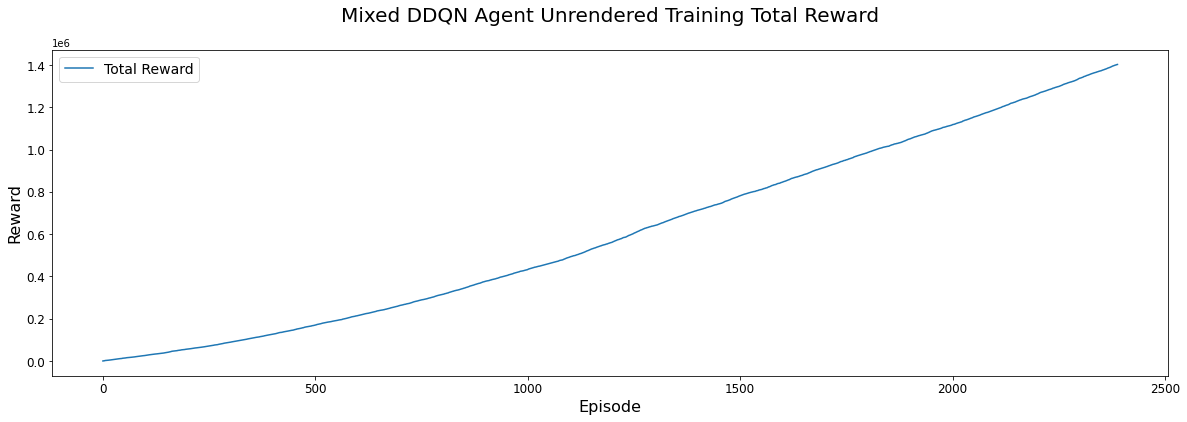

In [14]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Total Reward'], 
        x_label='Episode', 
        y_label='Reward',
        title='Mixed DDQN Agent Training Total Reward\n')

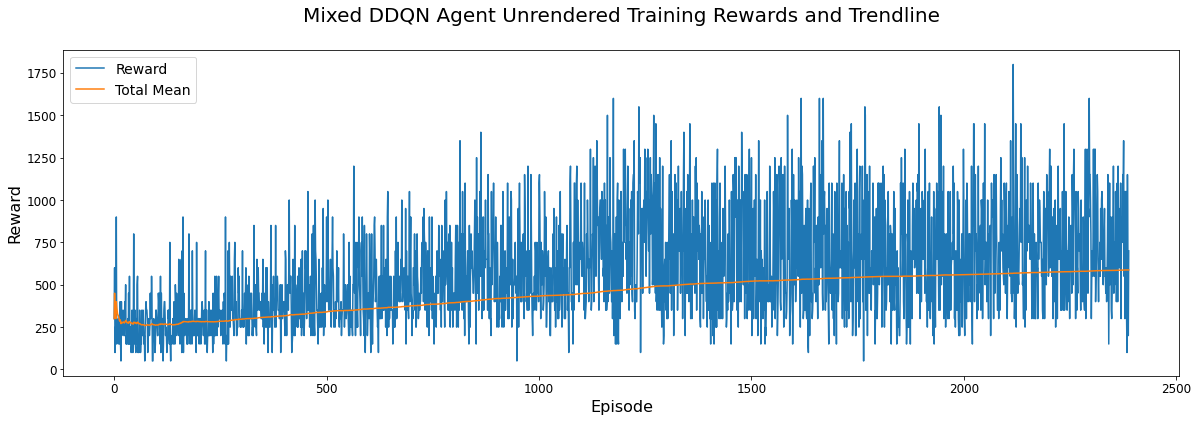

In [15]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Reward', 'Total Mean'], 
        x_label='Episode',
        y_label='Reward',
        title='Mixed DDQN Agent Training Rewards and Trendline\n')

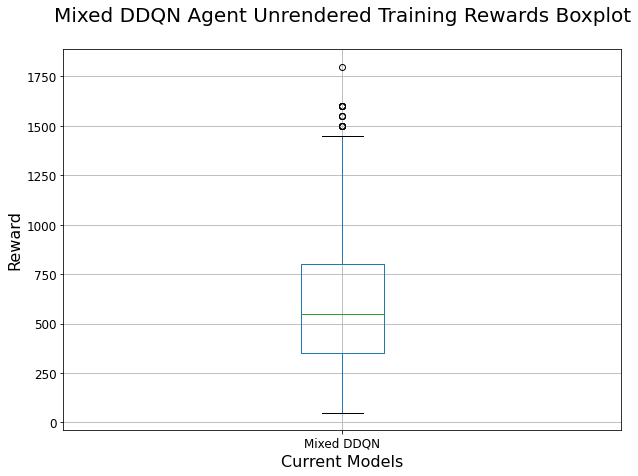

In [16]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot_for_episodes(train_df, 
                          ['Reward'], 
                          ['DDQN-Image'], 
                          x_label='Current Steps (50K)', 
                          y_label='Reward', 
                          title='Mixed DDQN Agent Training Rewards BoxPlot for each 50,000 steps')

In [ ]:
plot_violinplot_for_episodes(train_df, 
                             ['Reward'], 
                             ['DDQN-Image'], 
                             x_label='Current Steps (50K)', 
                             y_label='Reward', 
                             title='Mixed DDQN Agent Training Rewards ViolinPlot for each 50,000 steps')

In [17]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('current_model.csv')

### Architecture

In [18]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('mixed_ddqn_online_unrendered.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('mixed_ddqn_target_unrendered.h5')
ddqn_online.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 21, 21, 32)   10272       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 11, 11, 64)   32832       ['conv2d[0][0]']                 
                                                                                                  
 input_2 (InputLayer)           [(None, 640)]        0           []                               
                                                                                              

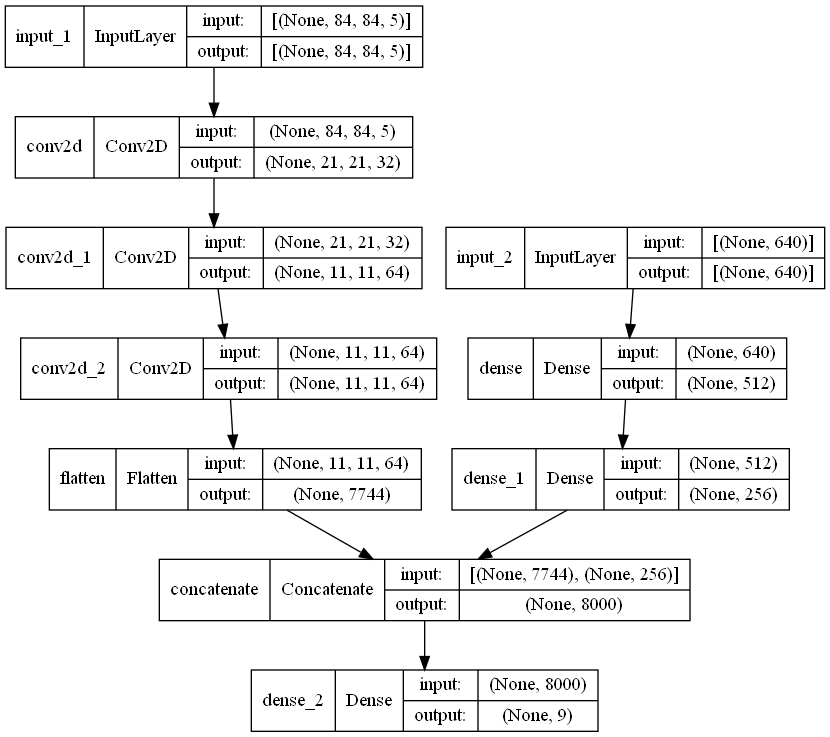

In [19]:
from tensorflow.keras.utils import plot_model

# Plot the mixed input DDQN and save it to a PNG file
plot_model(ddqn_online, to_file="architecture/mixed_ddqn.png", show_shapes=True)

## Task 3.3

For the comparison, please refer to Notebook `Plots` in the folder Assessment1 which contains all performed experiments. 